### Notebook to plot BOWTIE sounding data.

James Ruppert  
jruppert@ou.edu  
8/19/24

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, colors, ticker
import matplotlib.dates as mdates
from thermo_functions import *
import xarray as xr
import pandas as pd
from scipy import stats, signal
from bowtie_read_data import *

### Read in data

In [2]:
# Soundings
soundings, snd_files, times_snd = read_bowtie_soundings(search_string = 'ascen')
snd_vars = list(soundings.keys())[2:] # retain only 2-d variables in list

# Radiometer data
cwv_rdm, times_rdm = read_bowtie_radiometer()

# Sun photometer data
photom = read_bowtie_sunphotometer()

#### Mask out soundings that don't reach 100 hPa

In [3]:
nt = len(times_snd)
min_pres = np.zeros(nt)
for isnd in range(nt):
    min_pres[isnd] = np.nanmin(soundings['p'][isnd,:]*1e-2) # Pa --> hPa
min_pres = np.repeat(min_pres[:,np.newaxis], soundings['hght'].size, axis=1)
for ivar in snd_vars:
    soundings[ivar] = np.ma.masked_where((min_pres > 100), soundings[ivar], copy=False)

/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_79012/1316117976.py:4: RuntimeWarning: All-NaN slice encountered
  min_pres[isnd] = np.nanmin(soundings['p'][isnd,:]*1e-2) # Pa --> hPa


#### Smooth radiometer data

In [4]:
# Impose running average on CWV from radiometer
nt_sm = np.timedelta64(120, 'm') # 120-minute rolling average
dt_rdm = times_rdm[1]-times_rdm[0]
nt_smooth = int(nt_sm/dt_rdm)

cwv_rdm_pd = pd.DataFrame(cwv_rdm)
cwv_rdm_sm = cwv_rdm_pd.rolling(window=nt_smooth, center=True, closed='both', min_periods=20).mean()
cwv_rdm_sm = np.squeeze(cwv_rdm_sm)

### Compute diagnostics

In [5]:
# Vertical mass-weighted integral
#   inputs:
#       tmpk:   temperature [K]
#       mr:     water vapor mixing ratio [kg/kg]
#       p:      pressure [Pa]
#       hght:   height [m]
#   options:
#       minpres: set this to minimum pressure to integrate over [Pa]
def vert_integral(invar, tmpk, mr, p, hght, minpres=0):
    rho = density_moist(tmpk, mr, p) # kg/m3
    dz = hght[1]-hght[0] # m
    invar_masked = np.copy(invar)
    invar_masked[np.where(p < minpres)] = np.nan
    var_int = np.nansum(invar_masked*rho, axis=1)*dz
    # for iz in range(len(hght)):
    #     print(snd_asc['p'][15,iz])
    var_int[ np.where(np.isnan(soundings['p'][:,5])) ] = np.nan
    return var_int

In [6]:
# Constants
cp=1004.  # J/K/kg
cpl=4186. # J/k/kg
cpv=1885. # J/K/kg
lv0=2.5e6 # J/kg
g = 9.81 # m/s2
# Latent heat of vaporization
lv = lv0 - (cpl-cpv)*(soundings['tmpk']-273.15)

minpres=50e2 # Upper pressure bound for vertical integrals [Pa]

# MSE
dse = cp*soundings['tmpk'] + g*soundings['hght'][np.newaxis,:]
mse = dse + lv*soundings['mr']
mse_vint = vert_integral(mse, soundings['tmpk'], soundings['mr'], soundings['p'], soundings['hght'], minpres=minpres)

# CWV/PW
# 1/g int(q)dp = s2/m * kg/m/s2 --> kg/m2 --> x1/rho_l --> 10^-3 kg/m2*m3/kg --> 10^-3m = mm
# int<q*rho>dz = kg/m3*m = kg/m2 = mm
cwv = vert_integral(soundings['mr'], soundings['tmpk'], soundings['mr'], soundings['p'],
                    soundings['hght'], minpres=0) # mm or kg/m2
                    # hght, minpres=60000) # mm or kg/m2

### Find radiometer bias

In [7]:
# Get an array of times in sec for both datasets from some consistent baseline
t_start = np.datetime64('2024-08-17T00')
t_end = times_rdm.max()
t_ind_snd = np.where((times_snd >= t_start) & (times_snd <= t_end))[0]
t_ind_rdm = np.where((times_rdm >= t_start) & (times_rdm <= t_end))[0]
times_asc_sec = (times_snd[t_ind_snd]-t_start)/np.timedelta64(1, 's')
times_rdm_sec = (times_rdm[t_ind_rdm]-t_start)/np.timedelta64(1, 's')

cwv_interp = np.interp(times_asc_sec, times_rdm_sec, cwv_rdm_sm[t_ind_rdm])

bias = np.nanmean(cwv[t_ind_snd]) - np.nanmean(cwv_interp)
print('Bias:', bias, 'mm')

Bias: 3.843687964182486 mm


---
### Plotting routines

#### Plotting functions

In [31]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}

rc('font', **font)

In [32]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    # Use lag-1 autocorrelation to estimate N
    def acf(x, length=20):
        return np.array([1]+[np.corrcoef(x[:-i], x[i:])[0,1]  \
            for i in range(1, length)])
    ac = acf(a,length=2)[1]
    n = len(a)
    n *= (1-ac)/(1+ac)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

In [33]:
# Time series function

def plot_time_series(figdata, scatter=True, axline=False):
    fig, ax = plt.subplots(figsize=(8,4), layout="constrained")

    ax.set_title(figdata['title'])
    ax.set_ylabel(figdata['ylabel'])
    ax.set_xlabel('Date')

    sizes=20

    finite=np.where(np.isfinite(figdata['pltvar']))
    ax.plot(figdata['time'][finite], figdata['pltvar'][finite], color='black', zorder=1)#, linewidth=1.0)
    if scatter:
        ax.scatter(figdata['time'], figdata['pltvar'], s=sizes, zorder=2)

    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

    if axline:
        ax.axhline(y=figdata['axline'], color='red', linewidth=0.8, zorder=0)

    plt.show()
    plt.close()
    return

In [34]:
# Time series comparisons

def plot_time_series_comp(figdata, axline=False):

    fig, ax = plt.subplots(figsize=(8,4), layout="constrained")

    ax.set_title(figdata['title'])
    ax.set_xlabel('Date')
    ax.set_ylabel(figdata['ylabel'])

    t_max=np.max((figdata['time1'][-1],figdata['time2'][-1]))
    ax.set_xlim((figdata['time1'][0],t_max))
    # ax.set_xlim((figdata['time1'][-8*6],t_max))

    color1='red'
    color2='blue'
    color3='green'

    linewidth=1

    # First plot
    sizes=20
    finite=np.where(np.isfinite(figdata['pltvar1']))
    # ax.plot(figdata['time1'][finite], figdata['pltvar1'][finite], color=color1, zorder=1,
    #         label=figdata['label1'], linewidth=linewidth)
    ax.scatter(figdata['time1'], figdata['pltvar1'], label=figdata['label1'], s=sizes, zorder=3, c='black', alpha=0.5)
    mean1, h1 = mean_confidence_interval(figdata['pltvar1'][finite])

    if 'pltvar2' in figdata:
        ax.plot(figdata['time2'], figdata['pltvar2'], color=color2, zorder=2,
                label=figdata['label2'], linewidth=linewidth*.75)
        mean2, h2 = mean_confidence_interval(figdata['pltvar2'])
    if 'pltvar3' in figdata:
        sizes=np.full(len(figdata['time3']), 20)
        ax.scatter(figdata['time3'], figdata['pltvar3'], s=sizes, zorder=3, c=color3, alpha=0.5,
                   label=figdata['label3'])
        mean3, h3 = mean_confidence_interval(figdata['pltvar3'])
    # if 'pltvar4' in figdata:
    #     ax.plot(figdata['time4'], figdata['pltvar4'], '-.k', zorder=3,
    #             label=figdata['label3'], linewidth=linewidth)

    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

    xloc=figdata['time1'][2]
    tdelt=np.timedelta64(3, 'h')
    linewidth=2.5
    # ax.vlines(xloc,         ymin=mean1-h1, ymax=mean1+h1, color=color1, linewidth=linewidth)
    # ax.vlines(xloc+tdelt*2, ymin=mean2-h2, ymax=mean2+h2, color=color2, linewidth=linewidth)
    # ax.vlines(xloc+tdelt*3, ymin=mean3-h3, ymax=mean3+h3, color=color3, linewidth=linewidth)
    # ax.plot(xloc,         mean1, marker='o', color='black', markersize=2)
    # ax.plot(xloc+tdelt*2, mean2, marker='o', color='black', markersize=2)
    # ax.plot(xloc+tdelt*3, mean3, marker='o', color='black', markersize=2)

    if axline:
        ax.axhline(y=figdata['axline'], color='black', linestyle='--', linewidth=0.8, zorder=0)

    plt.legend(loc='lower right')

    plt.show()
    plt.close()
    return

In [35]:
def plot_time_height_subpanel(figdata, do_smooth=False, cwv=None, do_log=False, top=18):

    fig_x = 9
    # fig_y = 3.5
    # fig, ax = plt.subplots(figsize=(fig_x,fig_y), layout="constrained",) # row, column
    fig_y = 5
    fig, axs = plt.subplots(2, 1, figsize=(fig_x,fig_y), height_ratios=[.65,.4], layout='constrained',squeeze=True)

    # axs[0].set_title(figdata['fig_title'])

    axs[0].set_ylabel('Height [km]')
    axs[0].set_ylim(0,top)

    t_max=np.max((figdata['time1'][-1],figdata['time2'][-1]))
    xlim=(figdata['time1'][0],t_max)
    axs[0].set_xlim(xlim)
    # axs[0].set_xlabel('Date')

    axs[0].grid(True, axis='x', color='0.55', linewidth=0.5, zorder=4)
    axs[0].grid(True, axis='y', color='0.55', linewidth=0.5, zorder=4)#, which='both')

    # Plot variable
    xdim=figdata['time1']
    pltvar = figdata['pltvar0']
    if do_smooth:
        pltvar = do_smooth(pltvar)

    # norm=colors.Normalize(np.min(figdata['clevels']), np.max(figdata['clevels']))
    # im = ax.pcolormesh(np.repeat(xdim[:,np.newaxis],len(hght),axis=1), np.repeat(hght[np.newaxis,:]*1e-3,len(xdim),axis=0), pltvar, cmap=figdata['cmap'], shading='gouraud', norm=norm)#figdata['norm'])
    im = axs[0].contourf(xdim, soundings['hght']*1e-3, pltvar.transpose(), figdata['clevels'],
                    extend=figdata['extend'], cmap=figdata['cmap'], zorder=1)#, norm=figdata['norm'])
    fig.colorbar(im, ax=axs[0], label=figdata['units'], ticks=ticker.AutoLocator())#, shrink=0.6)

    # Line contours
    # im = axs[0].contour(xdim, hght*1e-3, pltvar.transpose(), figdata['clevels_line'],
    #                 colors=figdata['clevels_line_color'],linewidths=0.6, zorder=2)

    color1='red'
    color2='blue'
    color3='green'

    linewidth=1

    # Time labels
    axs[0].xaxis.set_major_locator(mdates.AutoDateLocator())
    axs[0].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[0].xaxis.get_major_locator()))

    # Hide labels
    axs[0].xaxis.set_ticklabels([])

    ##################################################

    # CWV SUBPANEL
    axs[1].set_ylabel('IWV [mm]')
    axs[1].set_ylim(40,75)

    # Time labels
    axs[1].set_xlim(xlim)
    axs[1].xaxis.set_major_locator(mdates.AutoDateLocator())
    axs[1].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[0].xaxis.get_major_locator()))

    # First plot
    sizes=20
    finite=np.where(np.isfinite(figdata['pltvar1']))
    # axs[1].plot(figdata['time1'][finite], figdata['pltvar1'][finite], color=color1, zorder=1,
    #         label=figdata['label1'], linewidth=linewidth)
    axs[1].scatter(figdata['time1'], figdata['pltvar1'], label=figdata['label1'], s=sizes, zorder=3, c='black', alpha=0.5)
    mean1, h1 = mean_confidence_interval(figdata['pltvar1'][finite])

    if 'pltvar2' in figdata:
        axs[1].plot(figdata['time2'], figdata['pltvar2'], color=color2, zorder=2,
                label=figdata['label2'], linewidth=linewidth*.75)
        mean2, h2 = mean_confidence_interval(figdata['pltvar2'])
    if 'pltvar3' in figdata:
        sizes=np.full(len(figdata['time3']), 20)
        axs[1].scatter(figdata['time3'], figdata['pltvar3'], s=sizes, zorder=3, c=color3, alpha=0.5,
                   label=figdata['label3'])
        mean3, h3 = mean_confidence_interval(figdata['pltvar3'])

    axs[1].set_xlabel('Date')

    axs[1].axhline(y=figdata['axline'], color='black', linestyle='--', linewidth=0.8, zorder=0)

    plt.show()
    plt.close()
    return

#### Minimum sounding pressure

/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_79012/647505528.py:4: RuntimeWarning: All-NaN axis encountered
  minpres[it] = np.nanmin(soundings['p'][it]*1e-2) # hPa
/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_79012/647505528.py:4: UserWarning: Warning: converting a masked element to nan.
  minpres[it] = np.nanmin(soundings['p'][it]*1e-2) # hPa


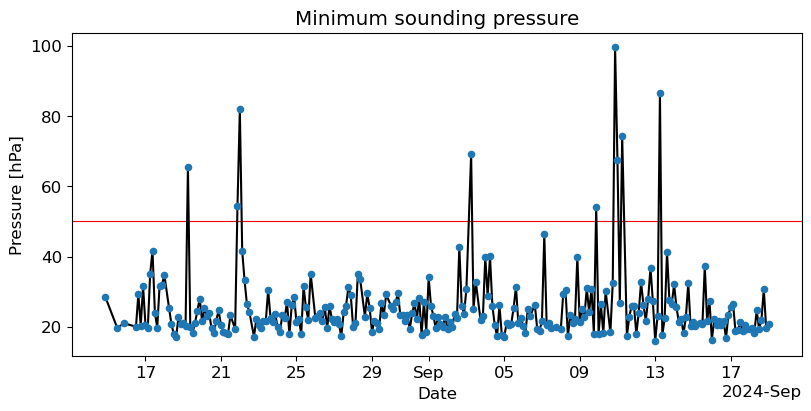

In [36]:
nt = soundings['p'].shape[0]
minpres = np.zeros(nt)
for it in range(nt):
    minpres[it] = np.nanmin(soundings['p'][it]*1e-2) # hPa
# minpres[np.where(minpres > pmax)]=pmax-1

figdata={
    'pltvar': minpres,
    'time': times_snd,
    'title': 'Minimum sounding pressure',
    'ylabel': 'Pressure [hPa]',
    'axline': 50,
    }

plot_time_series(figdata, axline=True)

#### Integrated water vapor (IWV) AKA Precipitable water (PW)

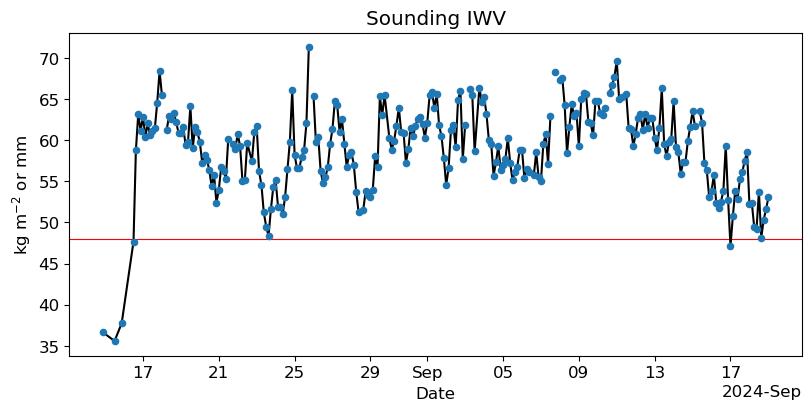

In [37]:
figdata={
    'pltvar': cwv,
    'time': times_snd,
    'title': 'Sounding IWV',
    'ylabel': 'kg m$^{-2}$ or mm',
    'axline': 48,
    }

plot_time_series(figdata, axline=True)

#### Data set comparison

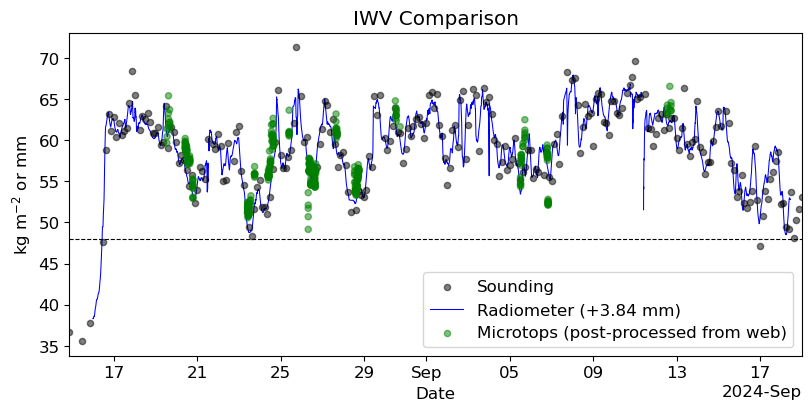

In [38]:
figdata={
    'pltvar1': cwv,
    'pltvar2': cwv_rdm_sm+bias,
    # 'pltvar2': iwv_rdm+bias,
    # 'pltvar2': iwv_rdm_sm,
    'pltvar3': photom['Water Vapor(cm)'],
    'time1': times_snd,
    'time2': times_rdm,
    'time3': photom['Date(dd:mm:yyyy)'],
    'label1': 'Sounding',
    'label2': 'Radiometer (+'+str(np.round(bias,decimals=2))+' mm)',
    # 'label2': 'Radiometer',
    'label3': 'Microtops (post-processed from web)',
    'title': 'IWV Comparison',
    'ylabel': 'kg m$^{-2}$ or mm',
    'axline': 48,
    }

plot_time_series_comp(figdata, axline=True)

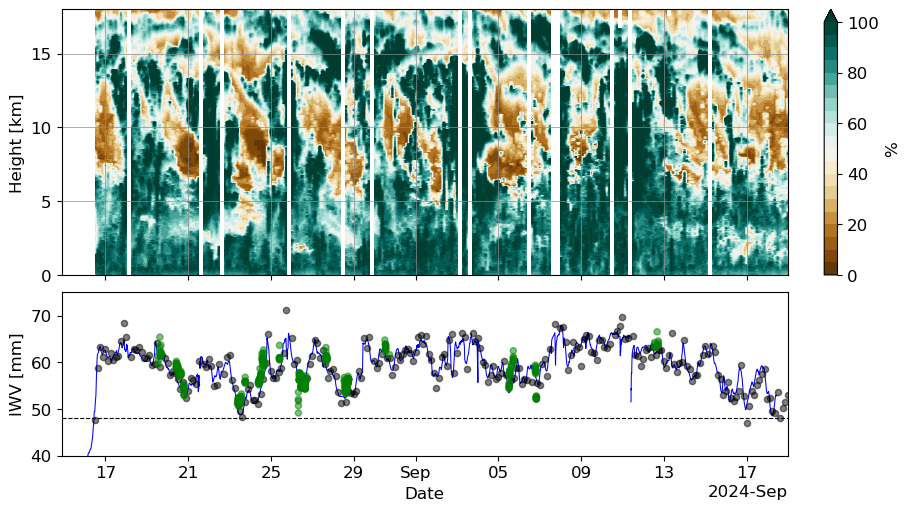

In [39]:
# RH with subpanel

cint_lines = 20
contours = np.arange(cint_lines,cint_lines*10,cint_lines)

figdata={
    'pltvar0': calc_relh(soundings['mr'], soundings['p'], soundings['tmpk'], ice=True),
    'clevels': np.arange(0,105,5),
    'clevels_line': contours,
    'clevels_line_color': 'black',
    'cmap': 'BrBG',
    'extend': 'max',
    'units': '%',
    'pltvar1': cwv,
    'pltvar2': cwv_rdm_sm+bias,
    # 'pltvar2': iwv_rdm_sm,
    'pltvar3': photom['Water Vapor(cm)'],
    'time1': times_snd,
    'time2': times_rdm,
    'time3': photom['Date(dd:mm:yyyy)'],
    'label1': 'Sounding',
    'label2': 'Radiometer (+'+str(np.round(bias,decimals=2))+' mm)',
    # 'label2': 'Radiometer',
    'label3': 'Microtops (post-processed from web)',
    'title': 'IWV Comparison',
    'ylabel': 'kg m$^{-2}$ or mm',
    'axline': 48,
    }

plot_time_height_subpanel(figdata)

In [40]:
# Print sounding CWV

# for itim in range(cwv.size):
#     print(times_snd[itim], cwv[itim])

#### CAPE/CIN

In [41]:
cape_sfc, cin_sfc = get_cape_cin(soundings['tmpk'], soundings['mr'], soundings['p'], type = 'sfc')
cape_mu, cin_mu = get_cape_cin(soundings['tmpk'], soundings['mr'], soundings['p'], type = 'mu')
# cape, cin = get_cape_cin(soundings['tmpk'][0:25], soundings['mr'][0:25], soundings['p'][0:25])

/Users/jamesruppert/miniforge3/envs/plotting/lib/python3.12/site-packages/numpy/ma/core.py:7099: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)
/Users/jamesruppert/code/PICCOLO/thermo_functions.py:177: RuntimeWarning: overflow encountered in exp
  * np.exp( (lv0 - (cpl-cpv)*((T+T0)-273.15))*rv / ((cp + cpl*rtot)*(T+T0)) )


In [64]:
# Time series function

def plot_time_series_capecin(figdata):
    fig, ax = plt.subplots(figsize=(8,4), layout="constrained")

    ax.set_title(figdata['title'])
    ax.set_ylabel(figdata['ylabel'])
    ax.set_xlabel('Date')

    linewidth=1.0
    color1='red'
    color2='blue'
    color3='green'
    sizes=20

    finite=np.where(np.isfinite(figdata['cape']))
    ax.plot(figdata['time'][finite], figdata['cape'][finite], color='black', alpha=0.7, zorder=1, linewidth=linewidth)
    ax.scatter(figdata['time'], figdata['cape'], s=sizes, color=color1, zorder=2, alpha=0.7, label=figdata['label1'])
    ax.scatter(figdata['time'], figdata['cape2'], s=sizes, color=color3, zorder=2, alpha=0.5, label=figdata['label2'])

    ax.plot(figdata['time'][finite], figdata['cin'][finite], color='black', alpha=0.7, zorder=1, linewidth=linewidth)
    ax.scatter(figdata['time'], figdata['cin'], s=sizes, color=color2, zorder=2, alpha=0.3, label=figdata['label3'])

    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

    plt.legend()#loc='lower right')

    # if axline:
        # ax.axhline(y=figdata['axline'], color='red', linewidth=0.8, zorder=0)

    plt.show()
    plt.close()
    return

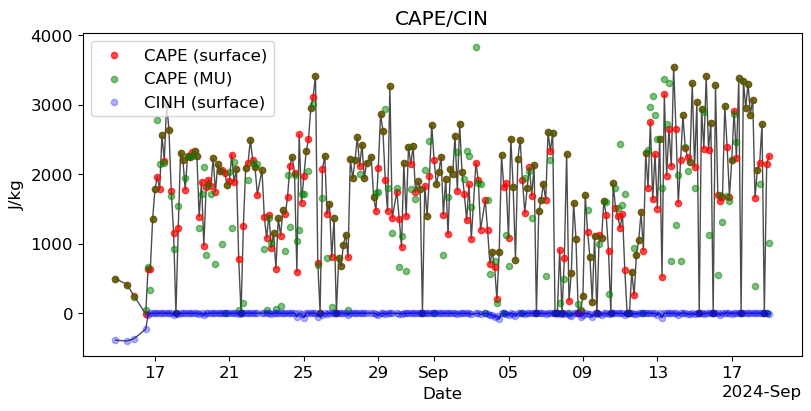

In [65]:
figdata={
    'cape': cape_sfc,
    'cape2': cape_mu,
    'cin': cin_sfc,
    'label1': 'CAPE (surface)',
    'label2': 'CAPE (MU)',
    'label3': 'CINH (surface)',
    'time': times_snd,
    'title': 'CAPE/CIN',
    'ylabel': 'J/kg',
    }

plot_time_series_capecin(figdata)